In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import davemodel
from davemodel import MyLogisticRegression, DaveModelBase
from importlib import reload


In [6]:
men_train = pd.read_csv("_RawData/mens_train_file.csv")
men_test = pd.read_csv("_RawData/mens_test_file.csv")
women_train = pd.read_csv("_RawData/womens_train_file.csv")
women_test = pd.read_csv("_RawData/womens_test_file.csv")


In [7]:
print(men_train.shape)
print(men_test.shape)
print(women_train.shape)
print(women_test.shape)


(5000, 28)
(2000, 28)
(5000, 28)
(1000, 28)


In [8]:
# Analyse data

men_analyse = pd.DataFrame(columns=["Name", "Type", "Unique", "NA"])

for col in men_train.columns:
    men_data = men_train[col]
    men_analyse = men_analyse.append({
        "Name": col, 
        "Type": men_data.dtype, 
        "Unique": men_data.nunique(), 
        "NA": men_data.isnull().sum()
    }, ignore_index=True)

men_analyse.sort_values(by = "Type")

,Name,Type,Unique,NA
23,server.is.impact.player,bool,2,0
20,same.side,bool,2,0
7,outside.sideline,bool,2,0
8,outside.baseline,bool,2,0
0,rally,int64,30,0
1,serve,int64,2,0
25,train,int64,1,0
24,id,int64,5000,0
22,previous.time.to.net,float64,5000,0
19,opponent.distance.from.center,float64,4505,0


In [9]:
men_train.head(10)

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,id,train,outcome,gender
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,12.5628,2.0724,True,F,0.445318,False,5718,1,UE,mens
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,12.3544,5.1124,False,B,0.432434,False,371,1,FE,mens
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,13.8620,1.6564,False,F,0.397538,True,7948,1,FE,mens
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,14.2596,0.1606,True,B,0.671984,True,9312,1,UE,mens
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,11.3658,1.1082,False,F,0.340411,False,7667,1,W,mens
5,10,1,B,39.012186,0.349889,0.485098,3.264708,True,False,0.804337,...,13.4220,2.0316,True,F,0.533950,False,9079,1,UE,mens
6,7,1,B,34.585672,1.234044,3.083445,1.222279,False,True,2.618520,...,12.2528,1.1038,False,F,0.409774,True,2598,1,UE,mens
7,3,1,F,34.445742,0.387828,0.873202,1.992689,False,False,1.925742,...,12.4838,4.5872,False,F,0.419794,True,7945,1,W,mens
8,11,2,F,21.830172,0.541135,0.494508,0.346735,False,True,3.074409,...,15.8012,2.8932,False,V,0.582123,True,231,1,UE,mens
9,20,1,F,45.379172,0.265430,1.307053,5.119994,False,False,4.842518,...,13.7284,1.6916,True,F,1.225011,False,327,1,W,mens


In [10]:
def speed_cat(prev_speed):
    speed = 0
    
    if prev_speed < 20:
        speed = 0
    elif prev_speed < 25:
        speed = 1
    elif prev_speed < 30:
        speed = 2
    elif prev_speed < 35:
        speed = 3
    elif prev_speed < 40:
        speed = 4
    else:
        speed = 5
        
    return speed

def net_clearance(clearance):
    net = 0
    
    if clearance < 0:
        net = 0
    elif clearance < 0.5:
        net = 1
    elif clearance < 1:
        net = 2
    elif clearance < 2:
        net = 3
    else:
        net = 4
        
    return net
        
# Remove unneeded columns
def process_data(data, gender):
    ids = data["id"].apply(lambda x: str(x) + "_" + gender)

    cat_cols = ["server.is.impact.player", "same.side", "outside.baseline", "outside.sideline", "serve", "hitpoint", "previous.hitpoint"]
    cat_cols += ["easy.shot", "net.clearance.group", "prev.speed.group", "speed.group"]
    drop_cols = ["id", "train", "gender", "outcome", "previous.speed", "speed", "net.clearance"]
#                  "previous.speed", "opponent.distance.from.center", "previous.depth", "previous.net.clearance"]
    drop_cols += cat_cols
    num_cols = [x for x in data.columns.tolist() if x not in drop_cols]
#     num_cols += ["prev.speed.group", "speed.group"]
    print(len(cat_cols) + len(drop_cols) + len(num_cols))
    
    new_data = data.copy()
    
    
#         (men_train["outside.sideline"] == False) 
#     & (men_train["outside.baseline"] == False)
#     & (men_train["net.clearance"] > 0)

    new_data["prev.speed.group"] = new_data["previous.speed"].apply(lambda x: speed_cat(x))
    new_data["speed.group"] = new_data["speed"].apply(lambda x: speed_cat(x))
#     new_data["over.net"] = new_data["net.clearance"] > 0
    new_data["net.clearance.group"] = new_data["net.clearance"].apply(lambda x: net_clearance(x))
    
#     new_data["good.shot"] = ((new_data["outside.sideline"] == False)
#                             & (new_data["outside.baseline"] == False)
#                             & (new_data["net.clearance"] > 0))
    
    new_data["easy.shot"] = ((new_data["previous.speed"] < 30)
    & (new_data["opponent.distance.from.center"] > 2)
    & (new_data["previous.depth"] > 3)
    & (new_data["previous.net.clearance"] > 1)
    & (new_data["outside.sideline"] == False) 
    & (new_data["outside.baseline"] == False)
    & (new_data["net.clearance"] > 0))
    #     & (men_train["depth"] > 0.2)
    #     & (men_train["distance.from.sideline"] > 0.2)
    #     & (men_train["player.distance.travelled"] < 4)
    #     & (men_train["player.distance.from.center"] < 1)
    #     & (men_train["hitpoint"] != "F")
    
    
    new_data = pd.get_dummies(new_data, columns = cat_cols)
    
    for col in drop_cols:
        if new_data.columns.contains(col):
            new_data = new_data.drop([col], axis = 1)
            
    new_data[num_cols] = (new_data[num_cols] - new_data[num_cols].mean()) / new_data[num_cols].std()


            
    return ids, new_data

    
def get_train_data(data, gender):
    new_label = data["outcome"]
    ids, new_data = process_data(data, gender)

    return ids, new_data, new_label

men_ids, X_men, y_men = get_train_data(men_train, "mens")
women_ids, X_women, y_women = get_train_data(women_train, "womens")

men_test_ids, X_men_test = process_data(men_test, "mens")
women_test_ids, X_women_test = process_data(women_test, "womens")

print(X_men.shape)
print(y_men.shape)
print(X_women.shape)
print(y_women.shape)
print(X_men_test.shape)
print(X_women_test.shape)


43
43
43
43
(5000, 51)
(5000,)
(5000, 51)
(5000,)
(2000, 51)
(1000, 51)


In [11]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
# X_men[X_men["easy.shot"] == True].shape
X_men.head()

,rally,distance.from.sideline,depth,player.distance.travelled,player.impact.depth,player.impact.distance.from.center,player.depth,player.distance.from.center,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,previous.time.to.net,server.is.impact.player_False,server.is.impact.player_True,same.side_False,same.side_True,outside.baseline_False,outside.baseline_True,outside.sideline_False,outside.sideline_True,serve_1,serve_2,hitpoint_B,...,hitpoint_U,hitpoint_V,previous.hitpoint_B,previous.hitpoint_F,previous.hitpoint_U,previous.hitpoint_V,easy.shot_False,easy.shot_True,net.clearance.group_0,net.clearance.group_1,net.clearance.group_2,net.clearance.group_3,net.clearance.group_4,prev.speed.group_0,prev.speed.group_1,prev.speed.group_2,prev.speed.group_3,prev.speed.group_4,prev.speed.group_5,speed.group_0,speed.group_1,speed.group_2,speed.group_3,speed.group_4,speed.group_5
0,-0.556070,1.830812,0.693324,-0.808756,0.762886,-0.738909,0.612054,-1.042314,0.852426,0.330016,-1.699856,-0.018598,-0.292499,-0.516968,1,0,0,1,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,-0.556070,0.987769,-0.617805,-0.345224,0.300325,2.056659,0.166630,0.948868,-0.068022,-1.458892,-0.217178,-0.107019,1.965721,-0.584499,1,0,1,0,0,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,4.538600,1.883527,1.519057,0.528630,1.150147,-0.506976,0.624626,0.733424,-0.665135,-0.948881,-0.663091,0.532636,-0.601518,-0.767404,0,1,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,0.784633,-0.775933,-0.388228,-1.293952,0.619564,-1.633234,0.387663,-1.247052,0.678488,1.104211,-1.769436,0.701332,-1.712651,0.671082,0,1,0,1,1,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,-0.556070,-0.476397,0.286893,-0.333407,1.092496,-0.245167,0.810355,-0.963936,-0.995855,-0.646018,-0.175435,-0.526469,-1.008740,-1.066828,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [12]:
men_train[men_train["net.clearance"] < 0]["outcome"].value_counts()

UE    860
FE    536
W      30
Name: outcome, dtype: int64

In [13]:
men_train["player.impact.distance.from.center"].max()

7.7462

In [14]:
# men_train[(men_train["net.clearance"] < -0.04)]

In [15]:
men_train["outcome"].value_counts()

UE    2118
W     1684
FE    1198
Name: outcome, dtype: int64

In [16]:
men_train[(men_train["outside.sideline"] == True)]["outcome"].value_counts()

UE    625
FE    337
W       4
Name: outcome, dtype: int64

In [17]:
men_train[(men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    639
FE    315
W      15
Name: outcome, dtype: int64

In [18]:
men_train[(men_train["outside.sideline"] == True) & (men_train["outside.baseline"] == True)]["outcome"].value_counts()

UE    101
FE     55
W       2
Name: outcome, dtype: int64

In [19]:
men_train.shape

(5000, 28)

In [20]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False)]["outcome"].value_counts()

W     1667
UE     955
FE     601
Name: outcome, dtype: int64

In [21]:
men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [22]:
# men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0)]

In [23]:
# men_train[(men_train["outside.sideline"] == False) & (men_train["outside.baseline"] == False) & (men_train["net.clearance"] > 0) & (men_train["outcome"] != "W")]

In [24]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False) 
    & (men_train["net.clearance"] > 0)
#     & ((men_train["distance.from.sideline"] < 0.02) == False)
#     & ((men_train["depth"] < 0.02) == False)
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

In [25]:
men_train[
    men_train["hitpoint"] == "U"
]["outcome"].value_counts()

W     139
FE    106
UE    104
Name: outcome, dtype: int64

In [26]:
# Potential features
# Good shot
# Bad shot
# Easy shot
# Hard shot

In [27]:
men_train[
    (men_train["previous.speed"] < 30)
    & (men_train["opponent.distance.from.center"] > 2)
    & (men_train["previous.depth"] > 3)
    & (men_train["previous.net.clearance"] > 1)
    & (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     364
UE      3
Name: outcome, dtype: int64

In [28]:
men_train[
    (men_train["outside.sideline"] == False) 
    & (men_train["outside.baseline"] == False)
    & (men_train["net.clearance"] > 0)
#     & (men_train["depth"] > 0.2)
#     & (men_train["distance.from.sideline"] > 0.2)
#     & (men_train["player.distance.travelled"] < 4)
#     & (men_train["player.distance.from.center"] < 1)
#     & (men_train["hitpoint"] != "F")
]["outcome"].value_counts()

W     1639
UE     131
FE     111
Name: outcome, dtype: int64

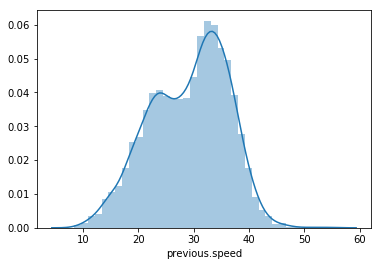

In [29]:
import seaborn as sns
%matplotlib inline
sns.distplot(men_train["previous.speed"])
# men_train["previous.speed"] < 30
# sns.regplot(men_train["previous.speed"], men_train["outcome"])

In [30]:
# men_train[(men_train["previous.speed"] < 25) & (men_train["outcome"] == "UE")]

In [34]:
men_train.head(10)

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,player.impact.depth,player.impact.distance.from.center,player.depth,player.distance.from.center,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,id,train,outcome,gender
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,14.1758,1.1448,13.6704,0.2330,32.313592,1.350533,2.449182,0.705435,12.5628,2.0724,True,F,0.445318,False,5718,1,UE,mens
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,12.7396,4.6258,12.6358,2.3162,34.060788,0.760499,0.583291,3.856600,12.3544,5.1124,False,B,0.432434,False,371,1,FE,mens
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,15.3782,1.4336,13.6996,2.0908,39.806628,0.377732,1.115250,2.908892,13.8620,1.6564,False,F,0.397538,True,7948,1,FE,mens
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,13.7308,0.0312,13.1492,0.0188,25.018818,1.239033,3.256695,0.557554,14.2596,0.1606,True,B,0.671984,True,9312,1,UE,mens
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,15.1992,1.7596,14.1310,0.3150,36.790979,0.165731,1.431146,3.945317,11.3658,1.1082,False,F,0.340411,False,7667,1,W,mens
5,10,1,B,39.012186,0.349889,0.485098,3.264708,True,False,0.804337,13.1496,0.6864,13.8902,1.0002,29.994187,0.486883,2.077335,5.007207,13.4220,2.0316,True,F,0.533950,False,9079,1,UE,mens
6,7,1,B,34.585672,1.234044,3.083445,1.222279,False,True,2.618520,14.1286,2.6224,14.0394,0.0054,34.154894,0.197445,1.646988,5.729710,12.2528,1.1038,False,F,0.409774,True,2598,1,UE,mens
7,3,1,F,34.445742,0.387828,0.873202,1.992689,False,False,1.925742,11.3576,2.4650,11.4776,0.5430,34.613076,0.227802,2.162769,5.043819,12.4838,4.5872,False,F,0.419794,True,7945,1,W,mens
8,11,2,F,21.830172,0.541135,0.494508,0.346735,False,True,3.074409,6.6490,0.9376,8.8890,1.1682,32.493635,0.490670,2.218269,5.738677,15.8012,2.8932,False,V,0.582123,True,231,1,UE,mens
9,20,1,F,45.379172,0.265430,1.307053,5.119994,False,False,4.842518,8.5002,1.3718,13.3046,0.7654,18.343119,4.346791,3.397722,4.251290,13.7284,1.6916,True,F,1.225011,False,327,1,W,mens


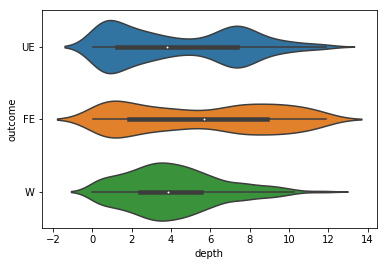

In [40]:
sns.violinplot(men_train["depth"], men_train["outcome"])

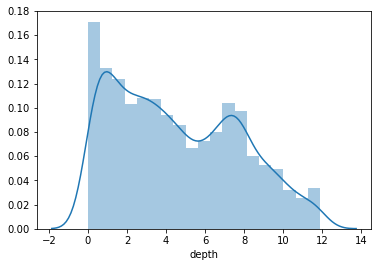

In [41]:
sns.distplot(men_train["depth"])

# < 1, 2, 3, 4, else

In [38]:
men_train["distance.from.sideline"].value_counts()

# Less than or equal to: 3, 4, 5, 6, 8, 11, 15, else

1.685928     1
2.084975     1
0.546154     1
0.955120     1
1.657374     1
1.627657     1
3.961531     1
1.366674     1
1.008098     1
0.835712     1
0.916274     1
2.066928     1
1.705997     1
1.602008     1
0.198761     1
1.210847     1
3.027267     1
0.139035     1
0.981569     1
0.308417     1
0.977872     1
0.793605     1
1.201267     1
0.867200     1
1.419265     1
2.630223     1
2.627538     1
1.012747     1
0.382153     1
1.990443     1
1.167523     1
3.884955     1
1.365104     1
0.728162     1
0.091108     1
2.267529     1
0.072510     1
1.891828     1
3.744523     1
1.291375     1
2.574017     1
1.078545     1
0.022825     1
1.157584     1
0.432033     1
0.627257     1
1.718822     1
2.391537     1
3.264841     1
0.226151     1
0.527003     1
2.844633     1
2.661131     1
1.042903     1
0.459124     1
0.270504     1
0.828839     1
0.096713     1
0.552360     1
2.503121     1
0.358957     1
1.956204     1
0.384769     1
0.325141     1
1.519031     1
0.048715     1
2.521526  

In [32]:
men_train[(men_train["rally"] < 4) & (men_train["server.is.impact.player"] == True)]["outcome"].value_counts()

UE    589
W     549
FE    181
Name: outcome, dtype: int64

In [33]:
men_train[
    (men_train["previous.speed"] > 35)
    & ((men_train["previous.depth"] < 1)
    | (men_train["previous.distance.from.sideline"] < 1))
    & (men_train["previous.net.clearance"] < 1)
    & (men_train["player.distance.travelled"] > 3)
]["outcome"].value_counts()

FE    125
UE     18
W      13
Name: outcome, dtype: int64

In [440]:
reload(davemodel)
from davemodel import MyLogisticRegression, MyRandomForest, MyXGBoost, MyBagging, MyGradientBoosting


In [441]:
xgb = MyXGBoost(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [442]:
xgb.run()


Training men...
Log loss: 0.0655140158704

Training women...
Log loss: 0.0717281517376

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)
Creating submission...
Done!
Saved


In [443]:
xgb.evaluate()

Log loss: 0.347882771873
Log loss: 0.322999404865


In [446]:
pred_men, pred_women = xgb.predict()


Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)


In [447]:
xgb.create_submission(pred_men, pred_women)

Creating submission...
Done!


In [299]:
forest = MyRandomForest(men_test_ids, X_men, y_men, X_men_test, women_test_ids, X_women, y_women, X_women_test)

In [300]:
forest.run()


Training men...
Log loss: 0.113053191619

Training women...
Log loss: 0.115107020642

Predicting men...
Prediction count: (2000, 3)

Predicting women...
Prediction count: (1000, 3)
Creating submission...
Done!
Saved


In [301]:
# forest.evaluate
forest.model_men.best_params_

{'max_depth': 13, 'max_features': 10, 'n_estimators': 60}

In [302]:
forest.model_women.best_params_

{'max_depth': 13, 'max_features': 20, 'n_estimators': 60}

In [303]:
forest.evaluate()

Log loss: 0.381428495174
Log loss: 0.357969562564
